In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import glob
import cv2

In [2]:
!ls ../input/proj2-ds/Covid19action-radiology-CXR_v1.1

Readme_CXR_Database_v1.1.pdf  Test_Source3_task2.csv  Train_Source3_task2.csv
Test_Combined.csv	      Train_Combined.csv      images


In [3]:
labels = pd.read_csv('../input/proj2-ds/Covid19action-radiology-CXR_v1.1/Train_Combined.csv')
print(labels.shape)
labels.drop(labels[(labels['Non-Pneumonia']==-1)|(labels['Other Pneumonia']==-1)].index, inplace=True)
print(labels.shape)
labels.head()

(228938, 6)
(210168, 6)


,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
0,CASE58_XRAY_1.jpeg,Source-2,1,0,0,1
1,case2_xray_1.jpeg,Source-2,1,0,0,1
2,case2_xray_2.jpeg,Source-2,1,0,0,1
3,case8_xray_1.jpeg,Source-2,1,0,0,1
4,case8_xray_2.jpeg,Source-2,1,0,0,1


Non-Pneumonia      199958
Other Pneumonia      9965
COVID-19              245
dtype: int64

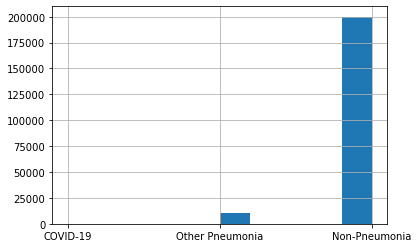

In [4]:
l = labels[['Non-Pneumonia', 'Other Pneumonia', 'COVID-19']].idxmax(axis=1)
l.hist()
l.value_counts()

In [5]:
# ignoring the Source-3 rows, since Source-3 dataset have 11GB total memory which is impossible for me to download at home.
print(labels.shape)
labels = labels[~labels['Data Source'].isin(['Source-3'])]
print(labels.shape)

(210168, 6)
(5524, 6)


In [6]:
df = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


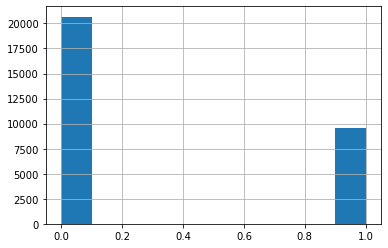

In [7]:
df['Target'].hist()

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import pydicom as dicom

In [9]:
from PIL import Image

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, targets, height, width):
        self.targets = targets
        self.height = height
        self.width = width
        
    def transform(self):
        return (transforms.Compose([
            transforms.Resize(size=(self.height, self.width)),
            transforms.ToTensor()
        ]))
        
    def get_im_proj2(self, name):
        im = cv2.imread(name)
        if len(im.shape) != 3 or im.shape[2] != 3:
            im = np.stack((im,) * 3, -1)
        return im
    
    def get_im_s4(self, name):
        im = dicom.read_file(name).pixel_array
        if len(im.shape) != 3 or im.shape[2] != 3:
            im = np.stack((im,) * 3, -1)
        return im
        
    def __getitem__(self, index):
        label = self.targets.iloc[index]['disease']
        if self.targets.iloc[index]['name'].split('/')[3] == 'proj2-ds':
            im = self.get_im_proj2(self.targets.iloc[index]['name'])
        else:
            im = self.get_im_s4(self.targets.iloc[index]['name'])
        return self.transform()(Image.fromarray(im)), label
    
    def __len__(self):
        return len(self.targets.index)

In [10]:
a = "ubdns"
if a.split('.')[-1] == a:
    a+='.jpg'
    print(a)

ubdns.jpg


In [11]:
from sklearn.utils import shuffle
from torch.utils.data.sampler import SubsetRandomSampler

def get_targets_others(labels, base_path):
    labels = labels[~labels['Data Source'].isin(['Source-3'])]
    targets = pd.DataFrame({'name':pd.Series([], dtype=str), 'disease':pd.Series([], dtype=int)})
    classes = ['Non-Pneumonia', 'Other Pneumonia', 'COVID-19']

    for i, row in labels.iterrows():
        path1 = base_path+'Source'+row['Data Source'].split('-')[-1]+'/'+row['Image Name']
        if path1.split('/')[-1].split('.')[-1]==row['Image Name']:
            path1+='.jpg'
        if(row['Data Source'] == 'Source-4'):
            continue
        if os.path.isfile(path1):
            for indx, e in enumerate(classes):
                if row[e]==1:
                    targets = targets.append({'name':path1, 'disease':indx}, ignore_index=True)
                    break
        else:
            print('File: '+path1+" -- Doesn't exists")
            
    return targets
            
def get_targets_s4(df, base_path, test_size=0.05):
    seen = set()
    targets = pd.DataFrame({'name':pd.Series([], dtype=str), 'disease':pd.Series([], dtype=int)})
    for i, row in df.iterrows():
        path1 = base_path+row['patientId']+'.dcm'
        if path1 not in seen:
            seen.add(path1)
            targets = targets.append({'name':path1, 'disease':row['Target']}, ignore_index=True)
            
    seen.clear()
    targets = shuffle(targets)
    split = int(len(targets)*test_size)
    test_targets, train_targets = targets.iloc[0:split], targets[split:]
    
    return train_targets, test_targets

def create_dataset(test_size=0.05, valid_size=0.05, batch_size=512, height=35, width=35):
    labels = pd.read_csv('../input/proj2-ds/Covid19action-radiology-CXR_v1.1/Train_Combined.csv')
    base_path = '/kaggle/input/proj2-ds/Covid19action-radiology-CXR_v1.1/images/'
    train_targets = get_targets_others(labels, base_path)
    
    labels = pd.read_csv('../input/proj2-ds/Covid19action-radiology-CXR_v1.1/Test_Combined.csv')
    base_path = '/kaggle/input/proj2-ds/Covid19action-radiology-CXR_v1.1/images/'
    test_targets = get_targets_others(labels, base_path)
    
    df = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
    base_path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
    train_tgts, test_tgts = get_targets_s4(df, base_path, test_size)
    
    train_targets = pd.concat([train_targets, train_tgts])
    test_targets = pd.concat([test_targets, test_tgts])
    
    train_ds = custom_dataset(train_targets, height, width)
    test_ds = custom_dataset(test_targets, height, width)
    
    num_train = len(train_ds)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size*num_train))
    valid_idx, train_idx = indices[:split], indices[split:]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, sampler=valid_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)
    
    return train_loader, valid_loader, test_loader

In [12]:
class convNet(nn.Module):
    def __init__(self, num_classes=3):
        super(convNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(4*4*64, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
if torch.cuda.is_available():
    print("GPU is available :D")
    device = torch.device('cuda:0')
else:
    print("GPU is not available ;-;")
    device = torch.device('cpu')

GPU is not available ;-;


In [14]:
# Early Stopping class to stop when valid loss doesn't decrease further
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'LeNet_model.pt')
        self.val_loss_min = val_loss

In [15]:
# Training function
def training(model, learning_rate=0.001, patience=2, num_epochs=10):
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([20676/20676, 20676/6055, 20676/245]).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    train_loss = []
    valid_loss = []
    train_acc = []
    
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        tot = 0
        for i, (im, label) in enumerate(train_loader):
            print("Iteration: "+str(i))
            im = im.to(device)
            label = label.to(device)
            
            out = model(im)
            loss = criterion(out, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(out.data, 1)
            tot += preds.size(0)
            running_acc += torch.sum(preds==label).item()
            
        epoch_loss = running_loss/(i+1)
        epoch_acc = running_acc/(tot)
        
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        model.eval()
        total = 0
        running_valid_loss = 0.0
        with torch.no_grad():
            for (im, label) in valid_loader:
                im = im.to(device)
                label = label.to(device)

                out = model(im)
                running_valid_loss += criterion(out, label).item()
                total += label.size(0)
        
        epoch_valid_loss = running_valid_loss/total
        valid_loss.append(epoch_valid_loss)
        print('Epoch {:.0f}/{:.0f} : Training Loss: {:.4f} | Validation Loss: {:.4f} | Training Accuracy: {:.4f} %'
                    .format(epoch+1, num_epochs, epoch_loss, epoch_valid_loss, epoch_acc*100))
        
        early_stopping(epoch_valid_loss, model)
        if early_stopping.early_stop:
            print("Early Stopping!!!")
            break
            
    model.load_state_dict(torch.load('LeNet_model.pt'))
    return model, train_loss, valid_loss, train_acc

In [16]:
# Evaluation function
def evaluate(model):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for (im, label) in test_loader:
            im = im.to(device)
            label = label.to(device)
            
            out = model(im)
            _, preds = torch.max(out.data, axis=1)
            total += label.size(0)
            correct += (preds==label).sum().item()
            
        print('Test Accuracy : {} %'.format(100*correct/total))
        

In [17]:
num_epochs=10
patience=2
learning_rate=0.001

model = convNet()
train_loader, valid_loader, test_loader = create_dataset()
model, train_loss, valid_loss, train_acc = training(
                                                model,
                                                learning_rate=learning_rate,
                                                patience=patience,
                                                num_epochs=num_epochs
                                            )

File: /kaggle/input/proj2-ds/Covid19action-radiology-CXR_v1.1/images/Source6/COVID-00015a.jpg -- Doesn't exists
File: /kaggle/input/proj2-ds/Covid19action-radiology-CXR_v1.1/images/Source6/COVID-00015b.jpg -- Doesn't exists
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Epoch 1/10 : Training Loss: 1.0254 | Validation Loss: 0.0024 | Training Accuracy: 46.9540 %
Validation loss decrea

In [18]:
evaluate(model)

Test Accuracy : 66.61981728742094 %


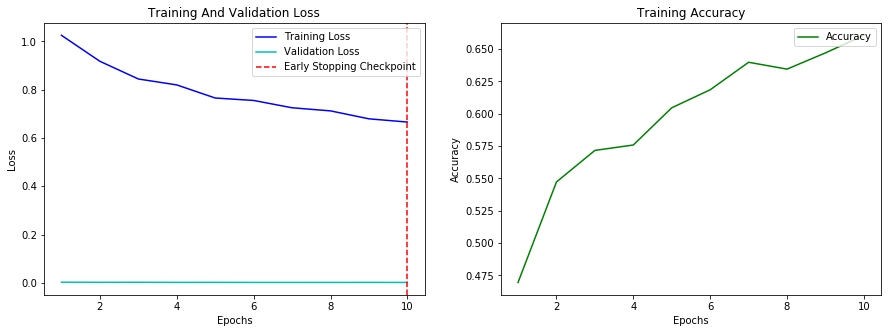

In [19]:
fig = plt.figure(figsize=[15, 5])

plt.subplot(121)
plt.plot(range(1, len(train_loss)+1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(valid_loss)+1), valid_loss, 'c', label='Validation Loss')
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.gca().set_title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(122)
plt.plot(range(1, len(train_acc)+1), train_acc, 'g', label='Accuracy')
plt.gca().set_title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')